In [19]:
import pandas as pd
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.calibration import calibration_curve

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 500

pio.renderers.default = "png"

In [5]:
test_with_predictions = pd.read_csv(
    "./results/test_with_predictions.csv",
    dtype={
        "mcc": str,
        "merchant_country": str,
        "pos_entry_mode": str,
        "merchant_zip": str,
    },
    index_col=0,
)

evaluation_metrics_df = pd.read_csv(
    "./results/evaluation_metrics_df.csv",
    index_col=0,
)

preprocessed = pd.read_csv(
    "./data/processed/preprocessed.csv",
    parse_dates=["transaction_time", "localized_transaction_time"],
    dtype={
        "mcc": str,
        "merchant_country": str,
        "pos_entry_mode": str,
        "merchant_zip": str,
    },
    index_col=0,
)

# encoded_df = pd.read_csv(
#     "./data/processed/encoded_df.csv",
#     index_col=0,
# )


# Preprocessed data set overview

In this notebook I perform a brief EDA of the preprocessed dataset which I later used for train-validation-test split. Later, I analyze random forest model results. 

In [6]:
# Class imbalance in the data set before train_val_test split. Fraudulent transactions make up less than 1% of all fraudulent transactions.
preprocessed.label.value_counts(normalize=True)

0    0.992715
1    0.007285
Name: label, dtype: float64

In [7]:
# Class imbalance in the test set after splitinig. 
test_with_predictions.label.value_counts(normalize=True)

0    0.992758
1    0.007242
Name: label, dtype: float64

In [8]:
transactions_per_month = (
    preprocessed.set_index("transaction_time")
    .groupby(pd.Grouper(freq="M"))[["event_id"]]
    .count()
)
transactions_per_month = transactions_per_month.reset_index()
transactions_per_month[
    "transaction_date"
] = transactions_per_month.transaction_time.dt.date

transactions_per_month.rename(columns={"event_id": "transaction_count"}, inplace=True)

monthly_average_number_of_transactions = round(
    transactions_per_month.transaction_count.mean()
)

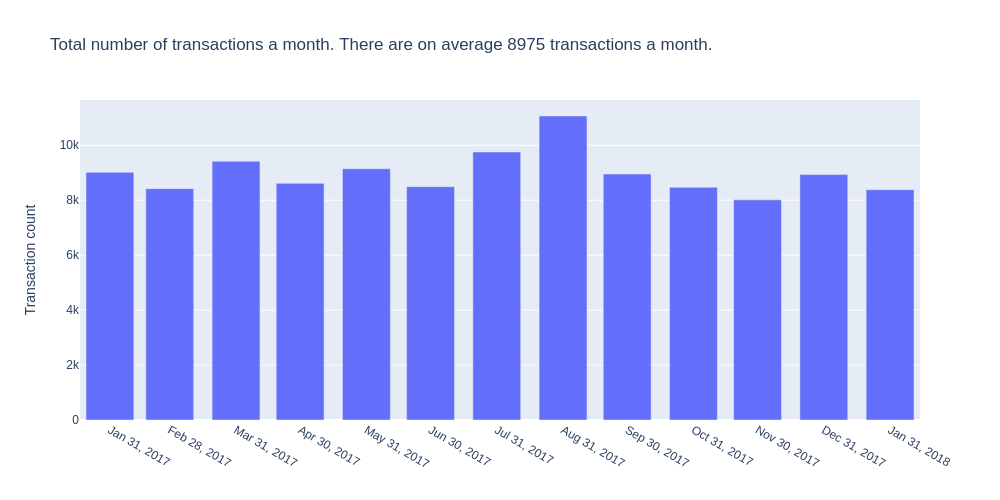

In [20]:
fig = px.bar(
    transactions_per_month,
    x="transaction_date",
    y="transaction_count",
    title=f"Total number of transactions a month. There are on average {monthly_average_number_of_transactions} transactions a month.",
)
fig.update_yaxes(title_text="Transaction count")
fig.update_xaxes(
    title_text=None, tickvals=list(transactions_per_month.transaction_time.dt.date)
)
fig.show()

In [10]:
fraud_per_month = (
    preprocessed[preprocessed.label == 1]
    .set_index("transaction_time")
    .groupby(pd.Grouper(freq="M"))
    .agg({"label": "sum", "account_number": "nunique", "transaction_amount": "sum"})
)

fraud_per_month = fraud_per_month.reset_index()
fraud_per_month["transaction_date"] = fraud_per_month.transaction_time.dt.date

monthly_average_number_of_fraud = round(fraud_per_month.label.mean())
monthly_average_fraudulent_transaction_amount = round(
    fraud_per_month.transaction_amount.mean()
)

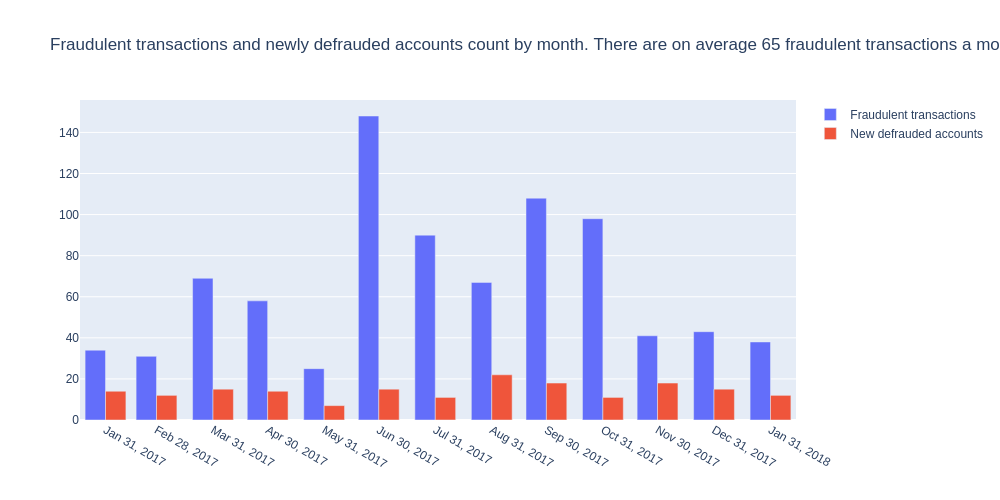

In [21]:
fig = go.Figure(
    data=[
        go.Bar(
            name="Fraudulent transactions",
            x=fraud_per_month["transaction_date"],
            y=fraud_per_month.label,
        ),
        go.Bar(
            name="New defrauded accounts",
            x=fraud_per_month["transaction_date"],
            y=fraud_per_month.account_number,
        ),
    ],
    layout=go.Layout(
        title=go.layout.Title(
            text=f"Fraudulent transactions and newly defrauded accounts count by month. There are on average {monthly_average_number_of_fraud} fraudulent transactions a month and it costs around {monthly_average_fraudulent_transaction_amount} pounds every month."
        )
    ),
)

fig.update_layout(barmode="group")
fig.update_xaxes(
    title_text=None, tickvals=list(fraud_per_month.transaction_time.dt.date)
)
fig.show()

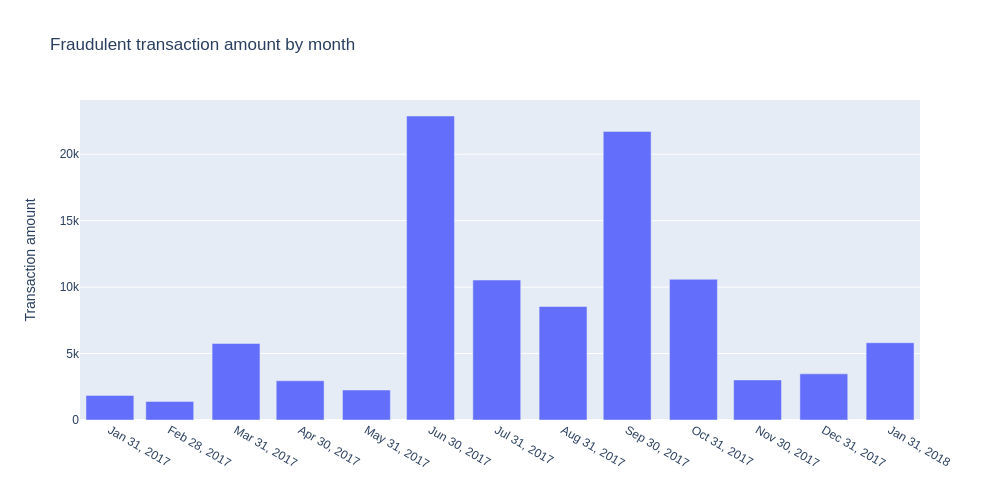

In [22]:
fig = px.bar(
    fraud_per_month,
    x="transaction_date",
    y="transaction_amount",
    title="Fraudulent transaction amount by month",
)
fig.update_yaxes(title_text="Transaction amount")
fig.update_xaxes(
    title_text=None, tickvals=list(fraud_per_month.transaction_time.dt.date)
)
fig.show()

# Random Forest Performance

## Calibration curve

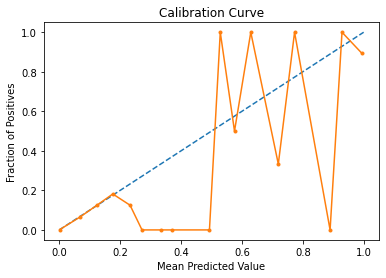

In [20]:
fop, mpv = calibration_curve(
    test_with_predictions.label,
    test_with_predictions.fraud_probability,
    n_bins=20,
    normalize=True,
)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(mpv, fop, marker=".")
plt.title("Calibration Curve")
plt.xlabel("Mean Predicted Value")
plt.ylabel("Fraction of Positives")
plt.show()

## Evaluation Metrics

The table below showcases threshold dependent metrics. Choosing the threshold of 0.015 brings good enough recall and helps stay within the workload limit.

In [21]:
evaluation_metrics_df

,Theshold,Recall,Precision,TP,FP,TN,FN,Total Workload,Saved Money,Defrauded Money,Saved Money %
0,0.000,1.000000,0.007242,65,8911,0,0,8976,6757,6757,100
1,0.005,0.923077,0.070588,60,790,8121,5,850,6698,6757,99
2,0.010,0.876923,0.112648,57,449,8462,8,506,5946,6757,88
3,0.015,0.846154,0.149051,55,314,8597,10,369,5931,6757,88
4,0.020,0.815385,0.181507,53,239,8672,12,292,5870,6757,87
...,...,...,...,...,...,...,...,...,...,...,...
205,1.025,0.000000,0.000000,0,0,8911,65,0,0,6757,0
206,1.030,0.000000,0.000000,0,0,8911,65,0,0,6757,0
207,1.035,0.000000,0.000000,0,0,8911,65,0,0,6757,0
208,1.040,0.000000,0.000000,0,0,8911,65,0,0,6757,0


## Feature importances

In [24]:
# rf_model = pickle.load(open("./fraud_detector/models/rf_model.pkl", "rb"))
# feature_names = encoded_df.columns

# feature_importance = pd.DataFrame({"Feature": feature_names,
#                              "Feature importance": rf_model.feature_importances_})
# feature_importance = feat_imp.sort_values("Feature importance", ascending=False)

95

In [ ]:
# fig = px.bar(feature_importance,  x="Feature importance", y="Feature", title="Feature Importance")
# fig.update_yaxes(title_text="Feature")
# fig.update_xaxes(
#     title_text="Importance")
# fig.show()